In [108]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image

from drunkenmarkov.Analysis import MarkovStateModel, TransitionPathTheory
from drunkenmarkov import Clustering
from drunkenmarkov.clustering import kmeans
from drunkenmarkov.Estimation import estimate_reversible, cmatrix
from drunkenmarkov.Visualization import draw_graph, draw_stationary, draw_graph_dominant, draw_spectrum


%matplotlib inline

In [109]:
def U(x):
    _x = x - 2.
    return _x**4 - 6. * _x**2 + 2. * _x

In [110]:
data = np.loadtxt('drunkenmarkov/data/example_1.dat')

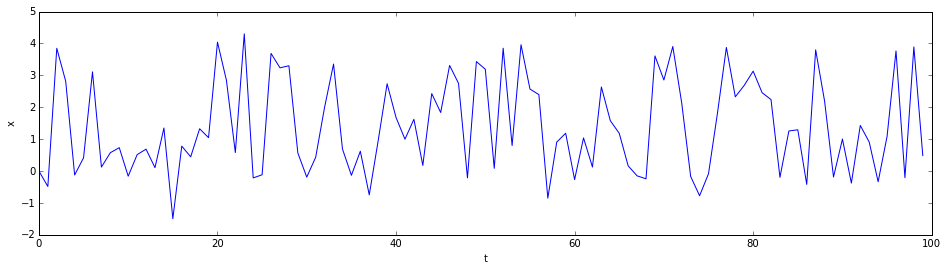

In [111]:
plt.figure(figsize=(16,4))

plt.xlabel('t')
plt.ylabel('x')

_ = plt.plot(data[0:100])

In [112]:
hist, edge = np.histogram(data, bins=100)

x = np.linspace(np.min(data), np.max(data), 10000)
y = U(x)

In [113]:
def twinx_plot(ax1, alphamapper=lambda x: 0.5, colormapper=lambda x: 'r'):
    ax1.plot(x, y, 'b-')
    ax1.set_xlabel('x')
    ax1.set_ylabel('U', color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
        
    width = 0.7 * (edge[1] - edge[0])
    center = (edge[:-1] + edge[1:]) / 2

    ax2 = ax1.twinx()
    for (index, bar) in enumerate(hist):
        ax2.bar(center[index], hist[index], align='center', width=width, alpha=alphamapper(index), color=colormapper(index))
    ax2.set_ylabel('Count', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
        
    return (ax1, ax2)

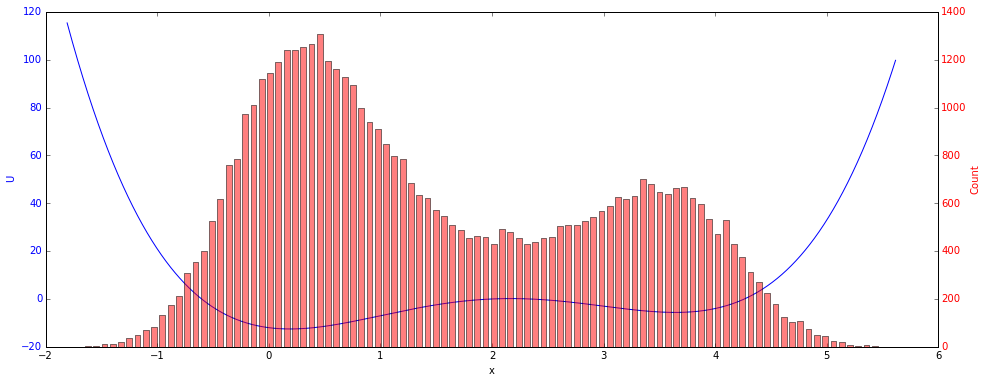

In [114]:
fig, ax1 = plt.subplots(figsize=(16, 6))
_ = twinx_plot(ax1)

In [115]:
clusters = Clustering.cluster(data, algorithm = kmeans.KMeans(k = 10, n_runs=1))

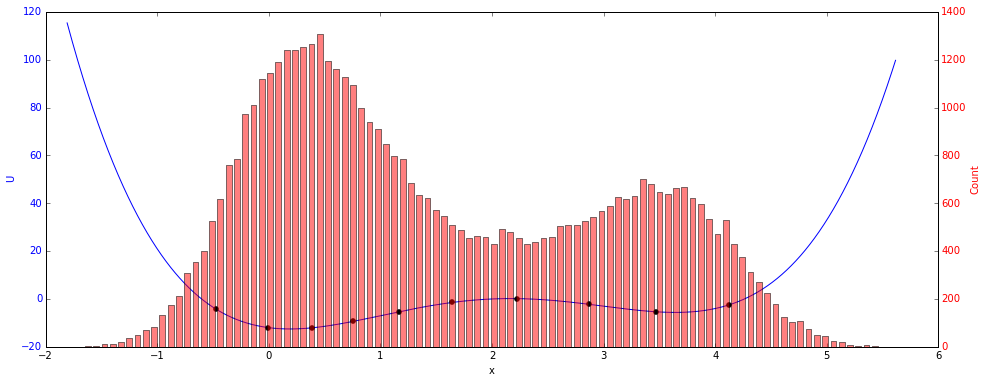

In [116]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1, ax2 = twinx_plot(ax1)

for i in range(len(clusters.centers)):
    ax1.plot(clusters.centers[i], U(np.array(clusters.centers).flatten())[i], 'ko', markersize=5)

In [117]:
discrete_trajectory = clusters.getDataMapping()

In [118]:
center = (edge[:-1] + edge[1:]) / 2

def get_nearest_cluster(ind, center):
    return np.argmin(np.sqrt(np.power(center[ind] - clusters.getClusterCenters(), 2)))

def get_nearest_reduced_state(ind, center):
    return np.argmin(membership[get_nearest_cluster(ind, center), :])

def get_assignment_probability(ind, center):
    return np.max(probabilities[get_nearest_cluster(ind, center)])

def map_discrete_trajectory_to_position(discrete_trajectory, mini, maxi):
    return [clusters.getClusterCenters()[discrete_trajectory[t]] for t in range(mini, maxi)]

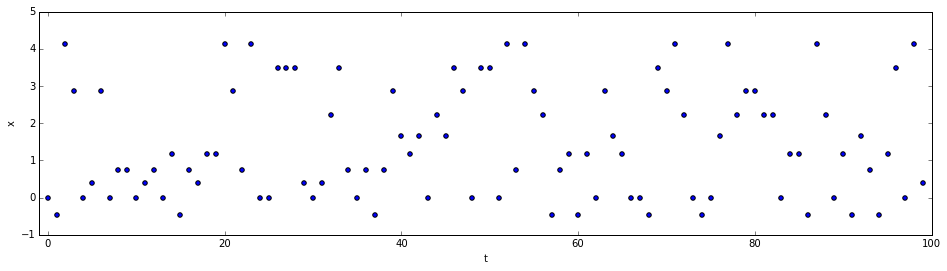

In [119]:
plt.figure(figsize=(16,4))

plt.xlabel('t')
plt.ylabel('x')

plt.xlim([-1, 100])

_ = plt.scatter(np.linspace(0, 99, 100), map_discrete_trajectory_to_position(discrete_trajectory, 0, 100))

In [120]:
cmat = cmatrix(discrete_trajectory)
T = estimate_reversible(cmat)

In [121]:
def plot_transition_matrix(T):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.set_title('Transition Matrix')

    tplot = ax.pcolor(T)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    _ = fig.colorbar(tplot, cax=cbar_ax)

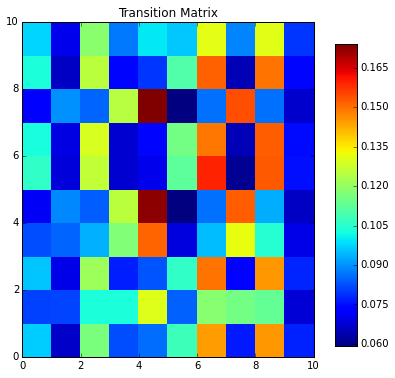

In [122]:
plot_transition_matrix(T)

In [123]:
MSM = MarkovStateModel(T)

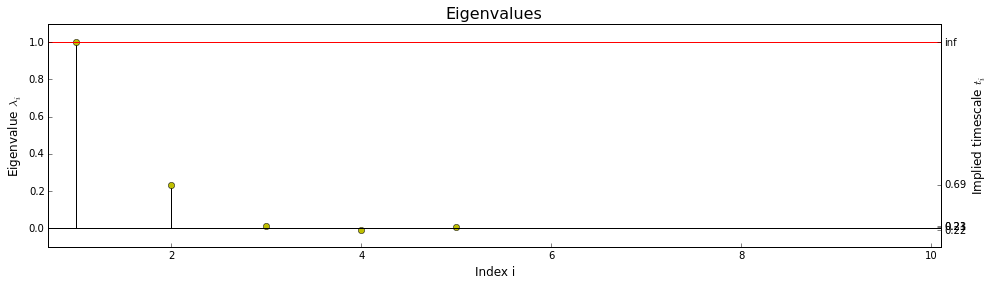

In [124]:
plt.figure(figsize=(16,4))

draw_spectrum(MSM)

In [125]:
graph = draw_graph(MSM, edge_threshold=0.02)

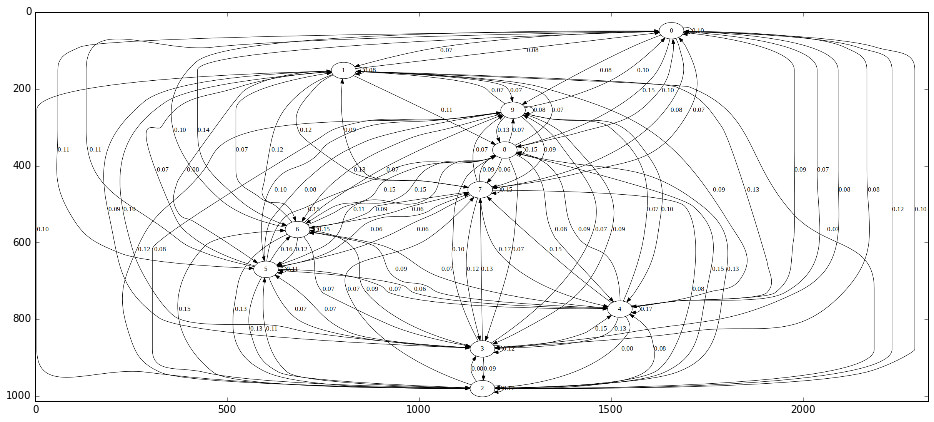

In [126]:
fig, ax = plt.subplots(figsize=(16, 16))

_ = plt.imshow(np.asarray(graph))

In [127]:
(T_reduced, membership, probabilities) = MSM.reduce_matrix(2)

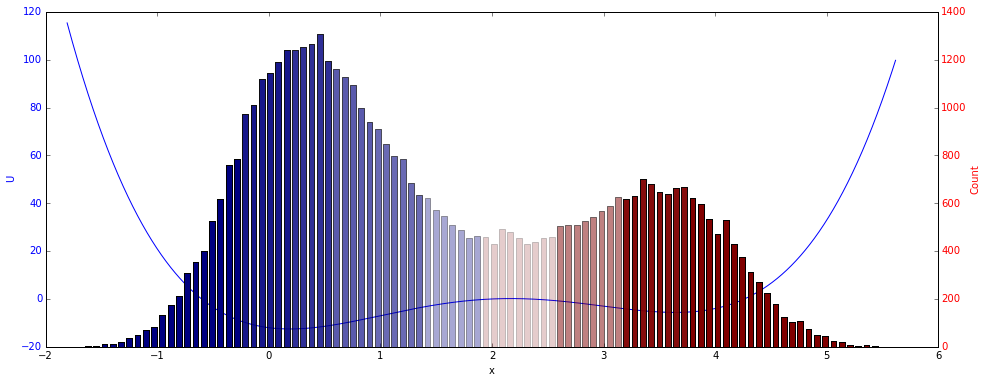

In [128]:
colormap = matplotlib.cm.get_cmap('jet', T_reduced.shape[0])

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1, ax2 = twinx_plot(ax1, 
                      colormapper=lambda x: colormap(get_nearest_reduced_state(x, center)),
                      alphamapper=lambda x: np.power(get_assignment_probability(x, center), 3))

In [129]:
MSM_reduced = MarkovStateModel(T_reduced)

In [130]:
graph = draw_graph(MSM_reduced, edge_threshold=0.02)

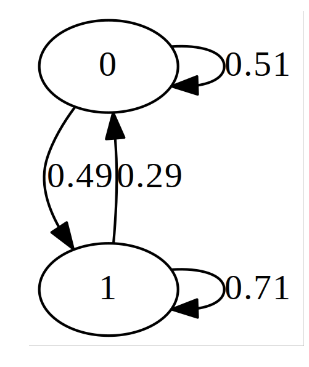

In [131]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(np.asarray(graph))
_ = ax.axis('off')

In [132]:
clusters = Clustering.cluster(data, algorithm = kmeans.KMeans(k = 5, n_runs=1))

In [133]:
discrete_trajectory = clusters.getDataMapping()
cmat = cmatrix(discrete_trajectory)
T = estimate_reversible(cmat)

MSM = MarkovStateModel(T)
(T_reduced, membership, probabilities) = MSM.reduce_matrix(2)

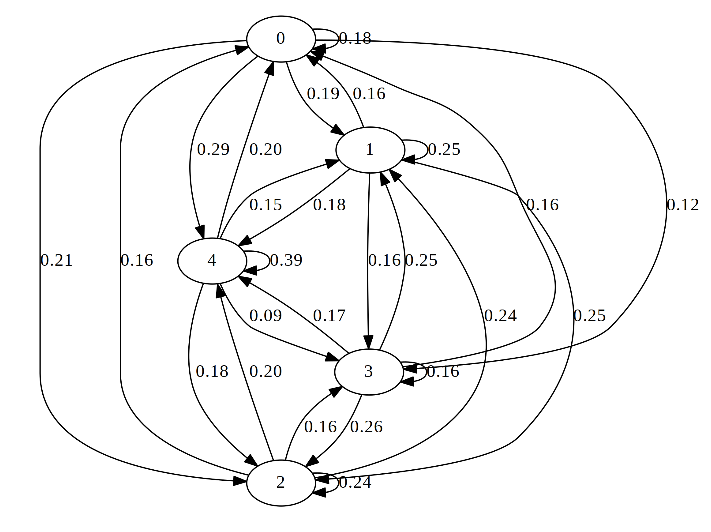

In [134]:
graph = draw_graph(MSM, edge_threshold=0.02)

fig, ax = plt.subplots(figsize=(12, 12))

ax.axis('off')
_ = plt.imshow(np.asarray(graph))

In [135]:
def get_assignments(reduced_id):
    return np.where(np.argmax(membership, axis=1) == reduced_id)[0].tolist()

In [136]:
tpt = TransitionPathTheory(T, get_assignments(0), get_assignments(1))

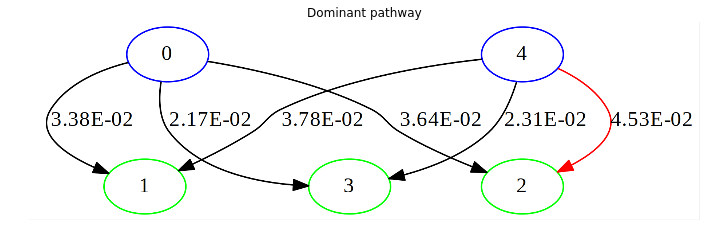

In [137]:
graph = draw_graph_dominant(tpt)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(np.asarray(graph))
ax.axis('off')
_ = ax.set_title('Dominant pathway')

In [138]:
tpt = TransitionPathTheory(T, get_assignments(1), get_assignments(0))

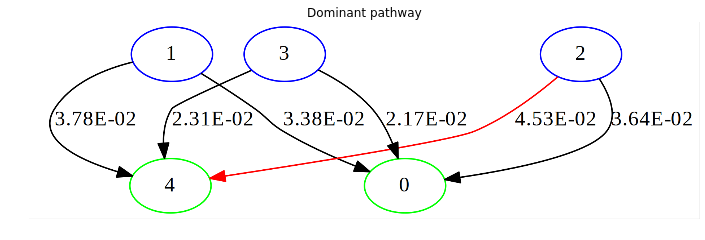

In [139]:
graph = draw_graph_dominant(tpt)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(np.asarray(graph))
ax.axis('off')
_ = ax.set_title('Dominant pathway')